# Guitar-note-recognition

### Exploring how one can recognize guitar notes by signal processing

### Introduction

### Theory

##### What is a guitar note?

 First of all a note is ... 
 
 When you pluck a guitar string, you determine the initial shape (displacement) and velocity of the string. The vibration of the string is governed by the one‐dimensional waveequation:

$$
\begin{cases}
    u_{tt}(x,t) = c^2 u_{xx}(x,t), & 0 < x < L, \quad t > 0 \\[8pt]
    u(0,t) = 0, \quad u(L,t) = 0, & t \geq 0 \\[8pt]
    u(x,0) = f(x), & 0 \leq x \leq L \\[8pt]
    u_t(x,0) = g(x), & 0 \leq x \leq L
\end{cases}
$$


Furthermore, we know that the solution to the waveequation is equivalent to an infinite sum of eigenfunctions.

$$
u(x,t) = \sum_{n=1}^{\infty} A_n \sin\left(\frac{n\pi x}{L}\right) \cos\left(\frac{n\pi c\,t}{L}\right)
$$

This is in music theory known as overtones or harmonics. We have the dominant frequency for $n = 1$, but the solution is not a single wave and thus we get a frequency-spectrum. However, what can become tricky is that the dominant frequency is not nescessary the tone we observe. We thus have to analyze the spectrum and find the best match. We also note that in nature there is no such things as undertones so this makes our search easier.


##### Implementing the Fourier transform:

The Fourier Transform is an integral-transformation which we can use to decompose a time-domain single into the frequency-domain...

##### Identifying the note

Musical notes are based on the distance to a reference pitch, which most often in Western music is A4 with $f_{\text{A4}} = 440\,\text{Hz}$. Futhermore, Western music also utilizes 12-tone equal temperament meaning that each octave is divided into 12 steps "(...) such that the ratio of the frequencies of any adjacent pair of notes is the same."  https://en.wikipedia.org/wiki/Equal_temperament

This means that for each note $n$, where $n=0$ is A4, we have:

$$
f_{n} = 440\cdot 2^{\frac{n}{12}} \,\text{Hz}
$$
giving us that 

$$
n = 12\cdot \log_{2}\left(\frac{f_n}{440\,\text{Hz}}\right)
$$

However, this introduces a problem as the guitar is not tuned to perfect equal temperament and will not be perfectly tuned to $f_\text{A4} = 440\,\text{Hz}$ either. Instead a guitar will be compromised due to fixed frets. So down the neck the frets are spaced to follow the 12-tone formula. However, the frets spaced equally for each string which gives error as each string has a slightly different ideal placement. https://acousticguitar.com/why-your-guitar-wont-play-perfectly-in-tune-and-why-thats-ok/

We will however assume tempered tuning using the midi-standard in the beginning and modify if we see that it is nescessary. 



##### Noise Reduction

##### Measuring time and f sharply

##### When does a new tone begin?

We can try to use the short time energy:

$$
E(n) = \Sigma^{M-1}_{m=0}|x(nH + m)|^2
$$

Or the spectral flux given by the Euclidian distance between two spectra. Or a combination.

### Method

### Implementation

In [100]:
### Pseudocode

# 1. Import a wav file

# 2. Remove noise 

# 3. Divide signal into time windows

# 4. For each time window:
# a. Do a Fourier-transform with FFT
# b. Identify dominant frequencies
# c. Map frequencies into notes



In [101]:
### Import basic libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy


In [102]:
### Reading wave-file
import wave

def read_wav(file_path):
    """
    Reads a WAV file and returns the sample rate and audio data as a NumPy array.
    """
    with wave.open(file_path, 'rb') as wav_file:
        sample_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()
        audio_data = np.frombuffer(wav_file.readframes(num_frames), dtype=np.int16)
    return sample_rate, audio_data



In [103]:
### Generate example file

import numpy as np
import wave

def generate_sine_wave(frequency=440, duration=2, sample_rate=44100, amplitude=32767):
    """
    Generates a sine wave and saves it as a WAV file.

    Parameters:
    - frequency: Frequency of the sine wave in Hz (default 440 Hz for A4).
    - duration: Duration of the generated wave in seconds (default 2 seconds).
    - sample_rate: Sampling rate in Hz (default 44100 Hz).
    - amplitude: Amplitude of the wave (default 32767 for 16-bit PCM audio).

    Returns:
    - File path of the generated WAV file.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    waveform = (amplitude * np.sin(2 * np.pi * frequency * t)).astype(np.int16)

    file_path = f"C:/Users/victo/Documents/Github/GuitarRecognition/data/example_{frequency}Hz.wav"
    with wave.open(file_path, "w") as wav_file:
        wav_file.setnchannels(1)  # Mono
        wav_file.setsampwidth(2)  # 16-bit PCM
        wav_file.setframerate(sample_rate)
        wav_file.writeframes(waveform.tobytes())

    return file_path


In [104]:
# Define the mapping of semitone index to note name (using sharps)
NOTE_NAMES = ['A', 'A#', 'B', 'C', 'C#', 'D', 
              'D#', 'E', 'F', 'F#', 'G', 'G#']

def note_to_offset(note):
    """
    Given a note name (e.g., 'C4' or 'A#3'), calculate the semitone offset from A4 (440 Hz).
    """
    # Determine if the note has an accidental (sharp)
    if len(note) >= 3 and note[1] == '#':
        pitch = note[:-1]  # e.g., 'C#'
        octave = int(note[-1])
    else:
        pitch = note[0]    # e.g., 'E'
        octave = int(note[1:])
        
    # Get raw index from NOTE_NAMES
    raw_index = NOTE_NAMES.index(pitch)
    
    # Adjust for octave: notes C and above are considered part of the next octave in this scheme
    if raw_index >= NOTE_NAMES.index("C"):
        semitone_adjust = raw_index - 12
    else:
        semitone_adjust = raw_index
        
    offset = (octave - 4) * 12 + semitone_adjust
    return offset

def offset_to_note(offset):
    """
    Convert a semitone offset (relative to A4) into its note name (e.g., 'C4').
    This version uses the MIDI note number for correct octave handling.
    """
    midi = offset + 69  # MIDI note number for A4 is 69
    note_name = NOTE_NAMES[(midi - 9) % 12]  # Adjust index so that MIDI 69 maps to 'A'
    octave = (midi // 12) - 1
    return f"{note_name}{octave}"

def offset_to_freq(offset):
    """
    Convert a semitone offset (relative to A4) into frequency in Hz.
    """
    return 440 * 2**(offset/12)

# Number of frets on the guitar
num_frets = 24

# Standard tuning for a 6-string guitar (string number : open note)
tuning = {
    6: "E2",
    5: "A2",
    4: "D3",
    3: "G3",
    2: "B3",
    1: "E4"
}

# Dictionary to store the computed notes and frequencies for each string.
# The structure: guitar_notes[string_number] = [(fret, note_name, frequency), ...]
guitar_notes = {}

for string, open_note in tuning.items():
    open_offset = note_to_offset(open_note)
    notes_for_string = []
    for fret in range(num_frets + 1):
        current_offset = open_offset + fret
        note_name = offset_to_note(current_offset)
        freq = offset_to_freq(current_offset)
        notes_for_string.append((fret, note_name, freq))
    guitar_notes[string] = notes_for_string


In [105]:

# Example: print the computed information for string 6 (low E)
for fret, note_name, freq in guitar_notes[6]:
    print(f"String 6, Fret {fret}: {note_name} - {freq:.2f} Hz")


String 6, Fret 0: E2 - 82.41 Hz
String 6, Fret 1: F2 - 87.31 Hz
String 6, Fret 2: F#2 - 92.50 Hz
String 6, Fret 3: G2 - 98.00 Hz
String 6, Fret 4: G#2 - 103.83 Hz
String 6, Fret 5: A2 - 110.00 Hz
String 6, Fret 6: A#2 - 116.54 Hz
String 6, Fret 7: B2 - 123.47 Hz
String 6, Fret 8: C3 - 130.81 Hz
String 6, Fret 9: C#3 - 138.59 Hz
String 6, Fret 10: D3 - 146.83 Hz
String 6, Fret 11: D#3 - 155.56 Hz
String 6, Fret 12: E3 - 164.81 Hz
String 6, Fret 13: F3 - 174.61 Hz
String 6, Fret 14: F#3 - 185.00 Hz
String 6, Fret 15: G3 - 196.00 Hz
String 6, Fret 16: G#3 - 207.65 Hz
String 6, Fret 17: A3 - 220.00 Hz
String 6, Fret 18: A#3 - 233.08 Hz
String 6, Fret 19: B3 - 246.94 Hz
String 6, Fret 20: C4 - 261.63 Hz
String 6, Fret 21: C#4 - 277.18 Hz
String 6, Fret 22: D4 - 293.66 Hz
String 6, Fret 23: D#4 - 311.13 Hz
String 6, Fret 24: E4 - 329.63 Hz


In [106]:
from scipy.signal import stft

def analyze_stft(file_path, window_size=2048, hop_size=1024, window_type='hann'):
    """
    Reads an audio file, computes its short-time Fourier transform (STFT), 
    and identifies the dominant frequency in each time frame.
    
    Parameters:
    - file_path: Path to the WAV file.
    - window_size: Number of samples per window.
    - hop_size: Number of samples between successive windows.
    - window_type: Type of window to apply (default 'hann').
    
    Returns:
    - times: Array of time bins corresponding to each STFT window.
    - dominant_frequencies: Array of dominant frequency (in Hz) per time frame.
    - f: Frequency bins from the STFT.
    - Zxx: STFT complex spectrum.
    """
    # Read the audio file.
    sample_rate, audio_data = read_wav(file_path)
    
    # Compute the STFT.
    f, t, Zxx = stft(audio_data, fs=sample_rate, window='hann', nperseg=window_size, noverlap=window_size-hop_size)
    
    # For each time slice, find the frequency with maximum magnitude.
    dominant_frequencies = []
    for i in range(Zxx.shape[1]):
        # Consider only positive frequencies by default (f is positive when fs > 0)
        magnitudes = np.abs(Zxx[:, i])
        idx = np.argmax(magnitudes)
        dominant_frequencies.append(f[idx])
        
    return t, np.array(dominant_frequencies), f, Zxx




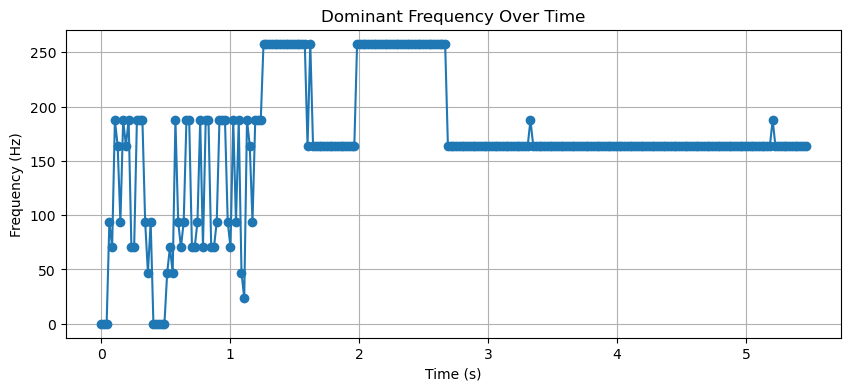

In [107]:

#file_path = generate_sine_wave()
file_path = "C:/Users/victo/Documents/Github/GuitarRecognition/data/gitar1.wav"

# Analyze the audio file using STFT.
times, dominant_frequencies, f, Zxx = analyze_stft(file_path)

# Plot the dominant frequency over time.
plt.figure(figsize=(10, 4))
plt.plot(times, dominant_frequencies, marker='o', linestyle='-')
plt.title("Dominant Frequency Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.grid(True)
plt.show()

We see that we get 430 Hz. This is from the bin size. However, reducin this means that we get greater time-intervals which means that we possibly can not pick up everything. So we now want to introduce an interpolation. We also see that it falls rapidly at the end. To fix this, we need to not include the endpoints.

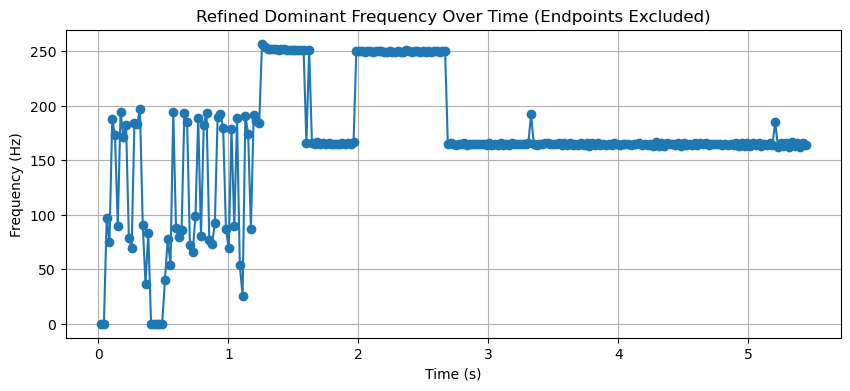

In [108]:
def quadratic_interpolation(magnitudes, peak_idx, bin_width):
    """
    Applies quadratic interpolation around the peak bin to refine the frequency estimate.

    Parameters:
    - magnitudes: Array of magnitudes for frequency bins.
    - peak_idx: Index of the maximum magnitude (peak) in the array.
    - bin_width: The frequency spacing between bins in Hz.

    Returns:
    - Correction (in Hz) to be added to the frequency at peak_idx.
    """
    if peak_idx <= 0 or peak_idx >= len(magnitudes) - 1:
        return 0.0
    # Magnitudes of the peak and its immediate neighbors
    alpha = magnitudes[peak_idx - 1]
    beta = magnitudes[peak_idx]
    gamma = magnitudes[peak_idx + 1]
    
    # Compute the correction factor (delta) based on the parabolic fit
    denominator = alpha - 2 * beta + gamma
    if denominator == 0:
        delta = 0
    else:
        delta = 0.5 * (alpha - gamma) / denominator
    return delta * bin_width

def analyze_stft_interpolated(file_path, window_size=2048, hop_size=1024, window_type='hann'):
    """
    Reads an audio file, computes its STFT, and identifies the refined dominant frequency 
    in each time frame using quadratic interpolation while skipping the endpoints.

    Parameters:
    - file_path: Path to the WAV file.
    - window_size: Number of samples per window.
    - hop_size: Number of samples between successive windows.
    - window_type: Type of window to apply.

    Returns:
    - times: Array of time bins (excluding the first and last frames).
    - interpolated_frequencies: Array of refined dominant frequency (in Hz) per time frame.
    - f: Frequency bins from the STFT.
    - Zxx: STFT complex spectrum.
    """
    # Read the audio file.
    sample_rate, audio_data = read_wav(file_path)
    
    # Compute the STFT.
    f, t, Zxx = stft(audio_data, fs=sample_rate, window=window_type, 
                       nperseg=window_size, noverlap=window_size-hop_size)
    
    # Frequency bin width in Hz (assuming uniform spacing)
    bin_width = f[1] - f[0] if len(f) > 1 else 0
    
    interpolated_frequencies = []
    refined_times = []
    
    # Exclude the first and last time frames to avoid edge artifacts.
    for i in range(1, Zxx.shape[1] - 1):
        magnitudes = np.abs(Zxx[:, i])
        peak_idx = np.argmax(magnitudes)
        # Basic frequency estimate from the peak index.
        basic_freq = f[peak_idx]
        # Calculate correction using quadratic interpolation.
        correction = quadratic_interpolation(magnitudes, peak_idx, bin_width)
        refined_freq = basic_freq + correction
        interpolated_frequencies.append(refined_freq)
        refined_times.append(t[i])
        
    return np.array(refined_times), np.array(interpolated_frequencies), f, Zxx

# Analyze the audio file using STFT with quadratic interpolation.
times, interpolated_frequencies, f, Zxx = analyze_stft_interpolated(file_path, window_size=2048, hop_size=1024)

# Plot the refined dominant frequency over time.
plt.figure(figsize=(10, 4))
plt.plot(times, interpolated_frequencies, marker='o', linestyle='-')
plt.title("Refined Dominant Frequency Over Time (Endpoints Excluded)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.grid(True)
plt.show()


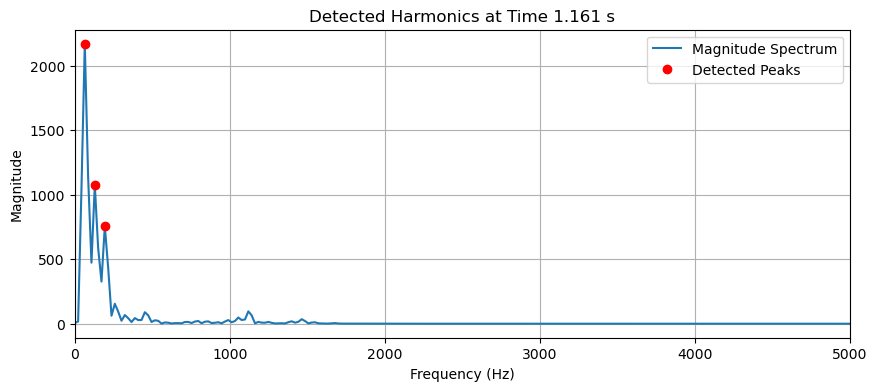

array([ 65.08224016, 130.33032642, 195.35576661])

In [109]:
from scipy.signal import find_peaks

def analyze_harmonics(file_path, window_size=2048, hop_size=1024, window_type='hann', 
                        peak_prominence=1e-6):
    """
    Reads an audio file, computes its STFT, and identifies multiple peaks (harmonics)
    in each time frame using a peak detection algorithm.

    Parameters:
    - file_path: Path to the WAV file.
    - window_size: Number of samples per window.
    - hop_size: Number of samples between successive windows.
    - window_type: Type of window to apply (default 'hann').
    - peak_prominence: Minimum prominence of peaks to consider (adjust based on signal amplitude).

    Returns:
    - times: Array of time bins corresponding to each STFT window.
    - harmonics_per_frame: List where each element corresponds to a time frame and contains a
      tuple of (refined_peak_frequencies, peak_magnitudes).
    - f: Frequency bins from the STFT.
    - Zxx: STFT complex spectrum.
    """
    # Read the audio file.
    sample_rate, audio_data = read_wav(file_path)
    
    # Compute the STFT.
    f, t, Zxx = stft(audio_data, fs=sample_rate, window=window_type, 
                       nperseg=window_size, noverlap=window_size-hop_size)
    bin_width = f[1] - f[0] if len(f) > 1 else 0

    harmonics_per_frame = []
    
    # Process each time frame.
    for i in range(Zxx.shape[1]):
        magnitudes = np.abs(Zxx[:, i])
        
        # Set a minimum threshold relative to the maximum magnitude in the frame.
        min_threshold = 0.1 * np.max(magnitudes)
        
        # Detect peaks in the magnitude spectrum with an added condition on minimum magnitude.
        peaks, properties = find_peaks(magnitudes, prominence=peak_prominence)
        
        # Filter out peaks that do not meet the minimum threshold.
        valid_peaks = peaks[magnitudes[peaks] >= min_threshold]
        peak_mags = magnitudes[valid_peaks]
        
        # Refine each detected peak using quadratic interpolation.
        refined_freqs = []
        for peak_idx in valid_peaks:
            if 0 < peak_idx < len(magnitudes) - 1:
                basic_freq = f[peak_idx]
                correction = quadratic_interpolation(magnitudes, peak_idx, bin_width)
                refined_freq = basic_freq + correction
            else:
                refined_freq = f[peak_idx]
            refined_freqs.append(refined_freq)
        
        harmonics_per_frame.append((np.array(refined_freqs), peak_mags))

    
    return t, harmonics_per_frame, f, Zxx

# Example usage:
file_path = "C:/Users/victo/Documents/Github/GuitarRecognition/data/Alesis-Fusion-Clean-Guitar-C3.wav"
times, harmonics, f, Zxx = analyze_harmonics(file_path)

# Plotting the detected harmonic frequencies for one time frame (e.g., the first frame):
import matplotlib.pyplot as plt

# Choose a specific time frame index to visualize (for example, index 10)
frame_idx = 50
detected_freqs, detected_mags = harmonics[frame_idx]

plt.figure(figsize=(10, 4))
plt.plot(f, np.abs(Zxx[:, frame_idx]), label='Magnitude Spectrum')
plt.plot(detected_freqs, detected_mags, 'ro', label='Detected Peaks')
plt.xlim(0, 5000)  # Only plot frequencies up to 5000 Hz
plt.title(f"Detected Harmonics at Time {times[frame_idx]:.3f} s")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.show()

detected_freqs

In [110]:
def find_note(detected_freqs, guitar_notes):
    """
    Given an array of detected frequencies and a guitar_notes dictionary (with keys as string numbers
    and values as lists of (fret, note_name, frequency) tuples), this function returns a list of note names
    corresponding to each detected frequency, based on the smallest frequency difference.
    
    Parameters:
    - detected_freqs: Array or list of frequencies to be matched.
    - guitar_notes: Dictionary mapping each string to a list of tuples (fret, note_name, frequency).
    
    Returns:
    - notes: List of note names that best match each detected frequency.
    """
    # Flatten the guitar_notes dictionary into a single list of candidate (note_name, frequency) pairs.
    candidate_notes = []
    for string, notes_list in guitar_notes.items():
        for fret, note_name, freq in notes_list:
            candidate_notes.append((note_name, freq))
    
    # For each detected frequency, find the candidate note with the smallest absolute frequency difference.
    notes = []
    for freq in detected_freqs:
        best_note = None
        min_diff = float('inf')
        for note_name, candidate_freq in candidate_notes:
            diff = abs(freq - candidate_freq)
            if diff < min_diff:
                min_diff = diff
                best_note = note_name
        if min_diff <= 5:
            notes.append(best_note)
        
    return notes


candidates = find_note(detected_freqs, guitar_notes)

In [111]:
def match_candidate_to_spectrum(candidate_freq, f, spectrum, num_harmonics=5, tolerance=5):
    """
    Computes a match score for a candidate note based on its expected harmonic series.

    Parameters:
    - candidate_freq: Fundamental frequency (Hz) of the candidate note.
    - f: Array of frequency bins from the STFT.
    - spectrum: Amplitude spectrum for a given time frame.
    - num_harmonics: Number of harmonics to consider (default 5).
    - tolerance: Tolerance in Hz to decide if a spectral peak is close enough to the expected harmonic.

    Returns:
    - match_score: A score reflecting how well the candidate's harmonics are represented.
    """
    match_score = 0.0
    for harmonic in range(1, num_harmonics + 1):
        expected_freq = candidate_freq * harmonic
        # Find the frequency bin closest to the expected harmonic.
        idx = np.argmin(np.abs(f - expected_freq))
        # If the difference is within the tolerance, add the amplitude to the score.
        if np.abs(f[idx] - expected_freq) < tolerance:
            match_score += spectrum[idx]
    return match_score

def best_match_from_candidates(candidates, f, spectrum, tolerance=5, num_harmonics=5):
    """
    Selects the candidate note that best fits the measured spectrum by comparing
    the energy in its expected harmonic frequencies.

    Parameters:
    - candidates: List of candidate note names (e.g., ['C3', 'E3']).
    - f: Array of frequency bins from the STFT.
    - spectrum: Amplitude spectrum for the chosen time frame.
    - tolerance: Frequency tolerance in Hz (default 5 Hz).
    - num_harmonics: Number of harmonics to consider for the matching score.

    Returns:
    - best_candidate: The candidate note name with the highest match score.
    - best_score: The corresponding match score.
    """
    best_score = -np.inf
    best_candidate = None

    for candidate in candidates:
        # Compute the fundamental frequency from the candidate note.
        offset = note_to_offset(candidate)
        candidate_freq = offset_to_freq(offset)
        score = match_candidate_to_spectrum(candidate_freq, f, spectrum, num_harmonics, tolerance)
        print(f"Candidate {candidate} (f0 = {candidate_freq:.2f} Hz) match score: {score:.2f}")
        if score > best_score:
            best_score = score
            best_candidate = candidate

    return best_candidate, best_score

# Example usage:
frame_idx = 50  # A random time frame

# Extract the amplitude spectrum for that frame.
spectrum_frame = np.abs(Zxx[:, frame_idx])

candidates = find_note(detected_freqs, guitar_notes)

best_candidate, best_score = best_match_from_candidates(candidates, f, spectrum_frame)
print(f"\nBest candidate note: {best_candidate} with score: {best_score:.2f}")




Candidate C3 (f0 = 130.81 Hz) match score: 1274.78
Candidate G3 (f0 = 196.00 Hz) match score: 800.36

Best candidate note: C3 with score: 1274.78


### Experiments and results

### Discussion

### Conclusion

### Deklarasjon av bruk av generativ kunstig intelligens

I dette vitenskapelige arbeidet har generativ kunstig intelligens (KI) blitt benyttet.  
Alle data og personopplysninger er blitt behandlet i henhold til Universitetet i Oslos reglement,  
og jeg som forfatter av dokumentet tar fullt ansvar for dets innhold, påstander og referanser.  

### Oversikt over bruken av generativ KI:
- Generering av LaTeX-script
- Stavekontroll
- Debugging av kode
- Finne funksjoner og biblioteker som passer til programmets behov
- Oppretting av docstrings og kommentering av kode
- Optimalisering av kode
- Faktasjekking
- Generering av korte kode-snutter basert på pseudokode
- Navngivning av variabler i henhold til konvensjoner

**Brukt språkmodell:** OpenAI ChatGPT


### References

http://audition.ens.fr/adc/pdf/2002_JASA_YIN.pdf